# Classifying Handwritten Digits

In [1]:
# Loading in the mnist dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
# Checking the shape of the predictors and target
X, y = mnist['data'], mnist['target']
print(X.shape, y.shape, sep='\n')

(70000, 784)
(70000,)


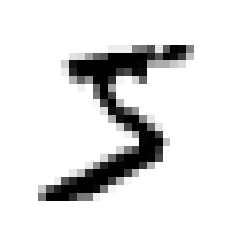

In [3]:
# plotting some digit and seeing if it checks out as its labeled value.
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [4]:
y[0]

'5'

In [5]:
# converting the target variable to the float dtype
import numpy as np
y = y.astype(np.uint8)

In [6]:
# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
# Only creating a classifier to check if a number is 5 or not 5
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [8]:
# Using the Stochastic Gradient Descent Classifier as our classification model
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True])

In [9]:
# Measuring accuracy using cross validation, first with the StratifiedKFold function to implement cross validation 
# ourselves 
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [10]:
# Now, using cross_val_score:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [11]:
# Using a dumb classifier that classifies every single image in the not-5 class
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [12]:
# using cross_val_predict to get an array of predictions for the confusion matrix
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [13]:
# using a confusion matrix to check the number of accurate predictions
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [14]:
# Checking the precision and recall scores
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred))

0.8370879772350012 0.6511713705958311


In [15]:
# Combining the precision and recall scores into one (f1_score)
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [16]:
# Understanding Precision/Recall tradeoff with decision functions
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[2164.22030239]
[ True]


In [17]:
# increasing the threshold decreases recall
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [18]:
# To decide which threshold to use, we use cross_val_predict but specify that we want to return decision scores
# insetead of predictions
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

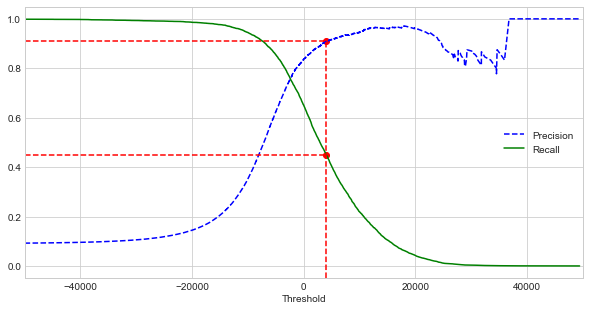

In [19]:
# with these scores, we then use the 'precision_recall_curve()' function to compute precision and recall for all
# thresholds
from sklearn.metrics import precision_recall_curve
precision, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# now use matplotliv to plot precision and recall as function of the threshold value
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    # setting style of plot
    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(10, 5))
    
    # plotting precision and recall
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    
    # highlighting the threshold
    plt.axhline(y = 0.91, xmin = 0., xmax = 0.54, color = 'r', linestyle = '--')
    plt.scatter(y=.91, x=4000, color='r')
    plt.axvline(x = 4000, ymax=.87, color='r', linestyle='--')
    plt.axhline(y = 0.45, xmin = 0., xmax = 0.54, color = 'r', linestyle = '--')
    plt.scatter(y=.45, x=4000, color='r')
    
    # adding legend, axis label and grid
    plt.legend()
    plt.xlim(-50000, 50000)
    plt.xlabel('Threshold')
    
plot_precision_recall_vs_threshold(precision, recalls, thresholds)

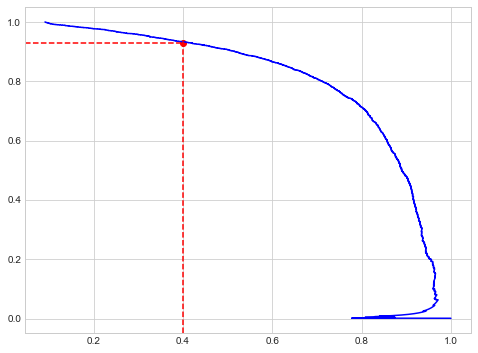

In [20]:
# We can also plot precision vs recall
plt.figure(figsize=(8, 6))
plt.plot(precision[:-1], recalls[:-1], color='b')
plt.axhline(y = 0.93, xmin = 0., xmax = 0.35, color = 'r', linestyle = '--')
plt.axvline(x = .4, ymax=.9, color='r', linestyle='--')
plt.scatter(y = .93, x=.4, color='r')
plt.show()

In [21]:
# setting the threshold to some other value to give us a high amount of precision
threshold_90_precision = thresholds[np.argmax(precision >= .90)]

y_train_pred_90 = (y_scores >= threshold_90_precision)

print(precision_score(y_train_5, y_train_pred_90),
      recall_score(y_train_5, y_train_pred_90),
     sep='\n')

0.9000345901072293
0.4799852425751706


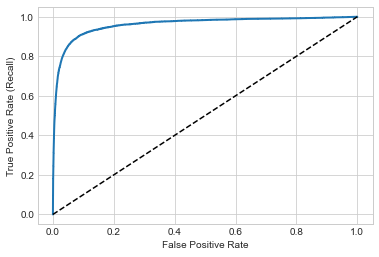

In [22]:
# plotting receiver operating characteristic (ROC) curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.show()
    
plot_roc_curve(fpr, tpr)

In [23]:
# Calculating area under the curve (AUC)
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

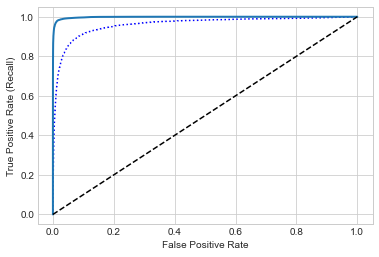

No handles with labels found to put in legend.


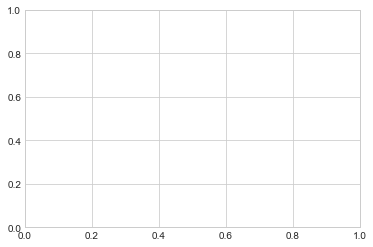

In [24]:
# comparing the roc curves and roc_auc score for RandomForestClassifier anf SGDClassifier

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [25]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [26]:
# using SVM classifier 
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [27]:
# Since svm_clf used the one vs one strategy, it splits into 10 classes. Class 5 was the correct prediction
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [28]:
# highest score indeed corresponds to 5
print(np.argmax(some_digit_scores),
      svm_clf.classes_,
      svm_clf.classes_[5],
      sep='\n')

5
[0 1 2 3 4 5 6 7 8 9]
5


In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

In [33]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

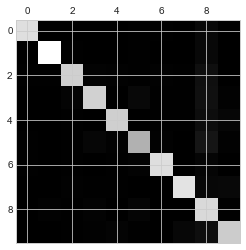

In [34]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

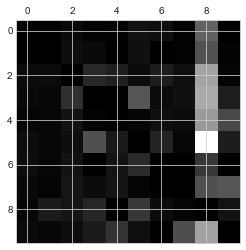

In [36]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [45]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [46]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])

array([[False,  True]])

In [48]:
y_train_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

NameError: name 'y_train_knn_pred' is not defined

In [49]:
f1_score(y_multilabel, y_train_pred, average='macro')

0.976410265560605